In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
if not os.path.exists('Figures'):
    os.makedirs('Figures')

In [3]:
data = pd.read_csv("./WaveformSummary.csv")

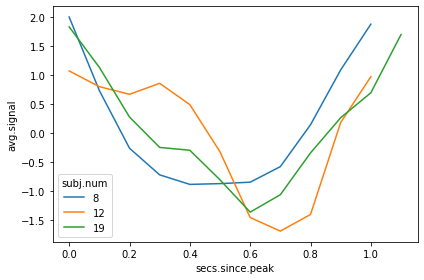

In [4]:
figure1 = plt.figure(figsize = (6,4))
figure1 = sns.lineplot(x="secs.since.peak",y="avg.signal",data=data,hue="subj.num",palette="tab10")
plt.tight_layout()
plt.savefig('Figures/figure1.png')

In [5]:
#separating data for gp
subject8 = data.loc[data['subj.num'] == 8 ]
subject12 = data.loc[data['subj.num'] == 12 ]
subject19 = data.loc[data['subj.num'] == 19 ]

In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import math 

In [7]:
def GP_fitting(df, timespan= 1, ell=0.1):
    x_train = df["secs.since.peak"].to_numpy()
    y_train = df["avg.signal"].to_numpy()
    y_var = df["sd.signal"].to_numpy()
    
    
    initial_scale = np.var(y_train)
    
    rbf_kernel = initial_scale * RBF(length_scale=ell, 
                                     length_scale_bounds=(ell/20, 5 * ell))
    
    y_var = y_var**2
    
    gp = GaussianProcessRegressor(kernel = rbf_kernel, alpha = y_var)
    
    x_vec = x_train.reshape((-1,1))
    
    fits = gp.fit(x_vec,y_train)

    oneSecond = np.linspace(0,timespan,int(timespan*1000))
    secAsvec = oneSecond[:,np.newaxis]
    
    nSamples = 1000
    ySampleMat = gp.sample_y(secAsvec,nSamples)
    y_mean,y_std = gp.predict(secAsvec,return_std=True)
    
    idx = np.random.randint(1000, size=10)
    subset = ySampleMat[:, idx]
    
    fig = plt.figure(figsize=(15,5))
    
    plt.plot(oneSecond, subset , color="lightblue" )
    plt.plot(oneSecond, y_mean,"--r")
    plt.fill_between(oneSecond,y_mean - y_std, y_mean + y_std,color="whitesmoke")
    plt.plot(x_train,y_train, "o")
    plt.ylabel("Signal",fontsize=15)
    plt.xlabel("Seconds since peak",fontsize=15)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.tight_layout()
    plt.show()
    
    return gp, ySampleMat, fig

In [8]:
def parameter_optimisation(gp):
    optimal_kernel = gp.kernel_
    optimal_params = optimal_kernel.get_params()
    ell = optimal_params["k2__length_scale"]
    A = math.sqrt( optimal_params["k1__constant_value"] )

    # make a grid in log A and ell
    nTicks = 50 
    tmp = np.linspace( math.log( A/2.0), math.log(2.0 * A), nTicks+1 )
    logA_grid = (tmp[0:nTicks] + tmp[1:(nTicks+1)]) /2

    tmp = np.linspace( math.log( ell/2.0), math.log(2.0 * ell), nTicks+1 )
    logEll_grid = (tmp[0:nTicks] + tmp[1:(nTicks+1)]) /2

    # Evaluate the likelihood on this grid
    loglike = np.zeros( [nTicks, nTicks])
    for j in range(0, nTicks):
        logEll = logEll_grid[j] ;
        for k in range(0, nTicks):
            logA = logA_grid[k]
            loglike[j,k] = gp.log_marginal_likelihood( [2*logA, logEll] ) 

    # Plot that puppy
    nLevels = 30
    colorMap = plt.get_cmap('RdYlBu')
    loglikeFig = plt.figure(figsize=[12,10])
    loglikeLevels = np.linspace( loglike.min(), loglike.max(), nLevels + 1)
    contourMap = plt.contourf(logA_grid, logEll_grid, loglike, levels=loglikeLevels, cmap=colorMap )
    plt.xlabel(r'log($A$)', fontsize=16)
    plt.ylabel(r'log($\ell$)', fontsize=16)
    cbar = plt.colorbar(contourMap)

    plt.scatter( x=math.log(A), y=math.log(ell), marker='o', color="red", s=50)
    plt.tight_layout()
    plt.show()
    
    return loglikeFig

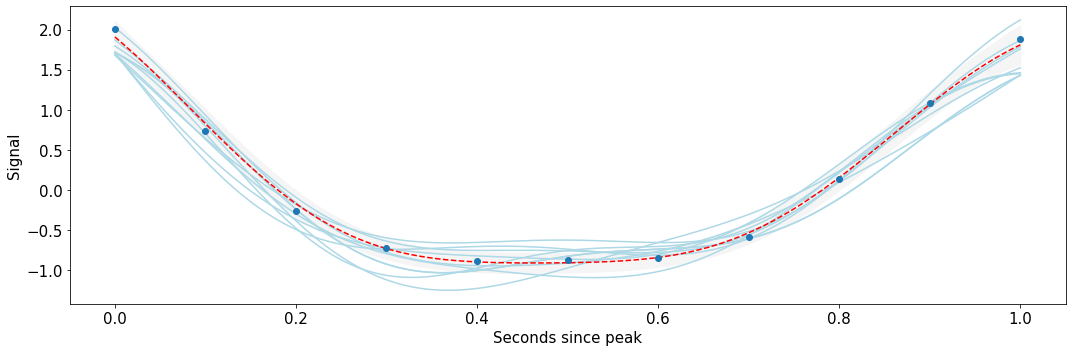

<Figure size 432x288 with 0 Axes>

In [9]:
subj8gp, subj8SampleMats, subj8main = GP_fitting(subject8,ell=0.05)
plt.tight_layout()
subj8main.savefig('Figures/subj8main.png')

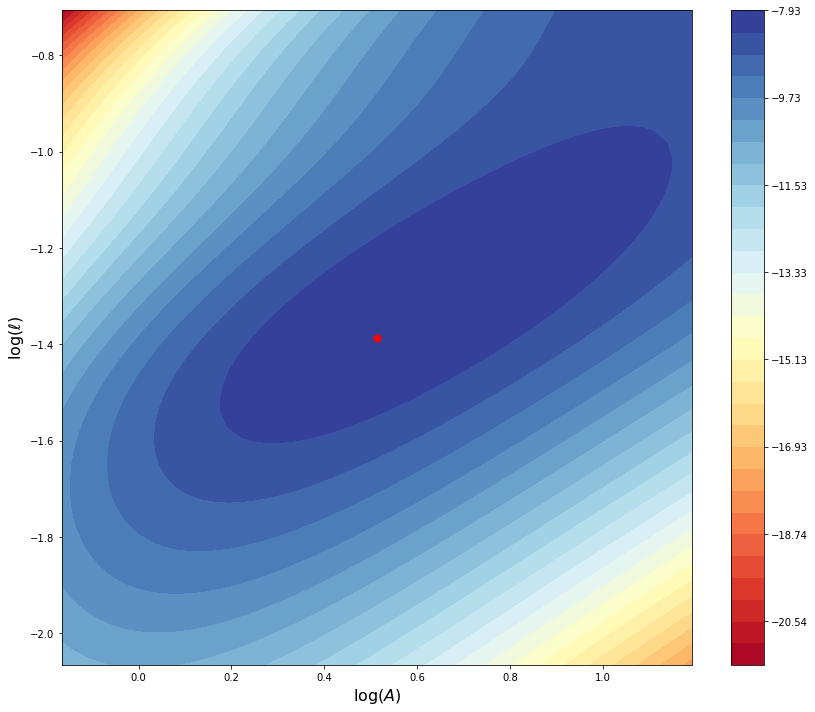

In [10]:
subj8paramsfig = parameter_optimisation(subj8gp)
subj8paramsfig.savefig('Figures/subj8paramsfig.png')

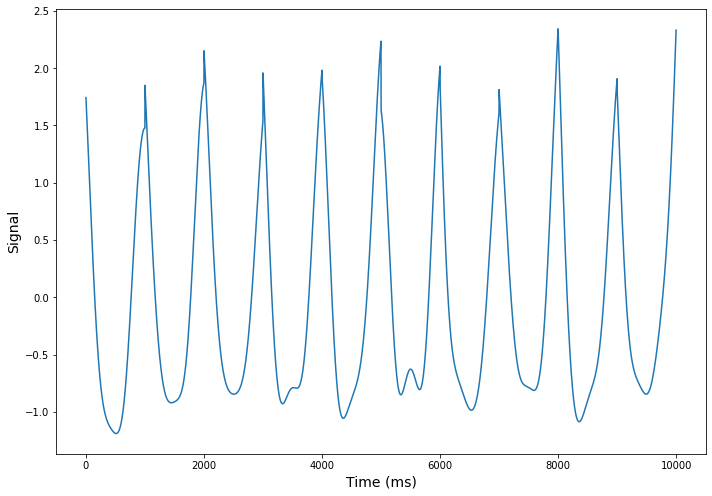

In [11]:
subj8 = subj8SampleMats[:, 0:10].flatten('F')
plt.figure(figsize=(10,7))
plt.plot(subj8)
plt.ylabel("Signal",fontsize=14)
plt.xlabel("Time (ms)",fontsize=14)
plt.tight_layout()
plt.savefig('Figures/subj8trace1.png')

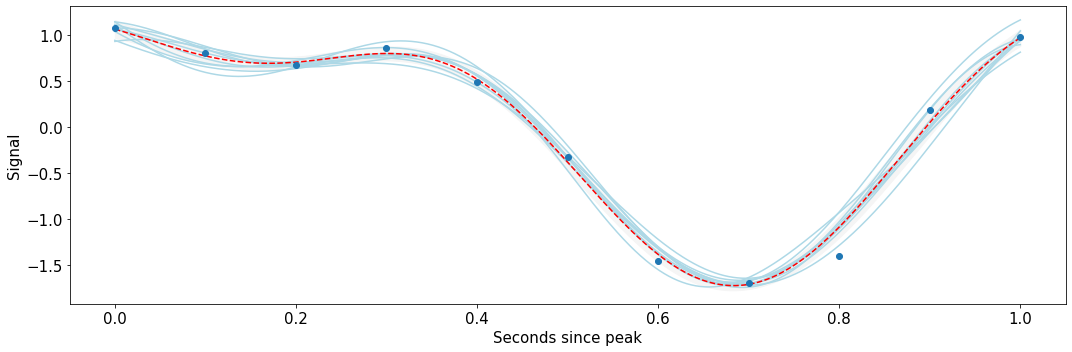

<Figure size 432x288 with 0 Axes>

In [12]:
subj12gp, subj12SampleMats,subj12main = GP_fitting(subject12, ell=0.045)
plt.tight_layout()
subj12main.savefig("./Figures/subj12main.png")

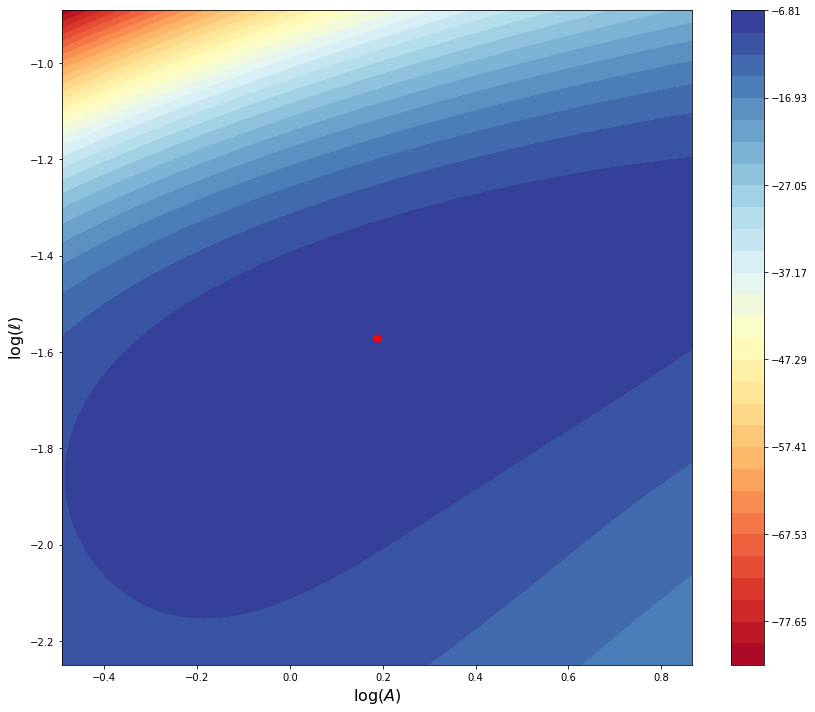

In [13]:
subj12paramsfig = parameter_optimisation(subj12gp)
subj12paramsfig.savefig("./Figures/subj12paramsfig.png")

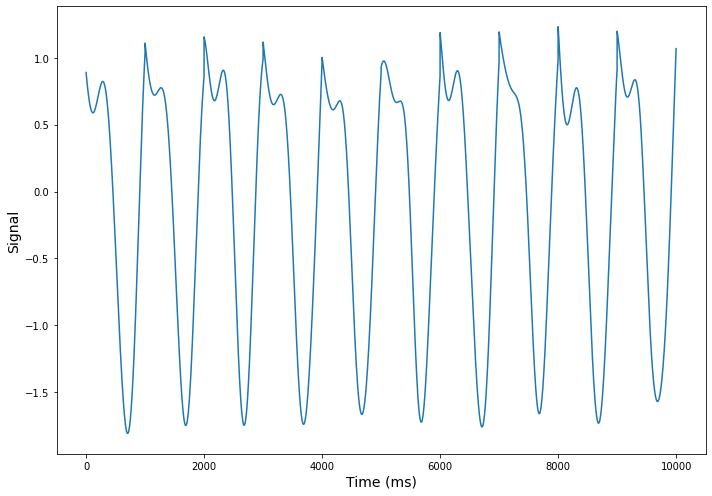

In [14]:
subj12 = subj12SampleMats[:, 0:10].flatten('F')
plt.figure(figsize=(10,7))
plt.plot(subj12)
plt.ylabel("Signal",fontsize=14)
plt.xlabel("Time (ms)",fontsize=14)
plt.tight_layout()
plt.savefig("./Figures/subj12trace")

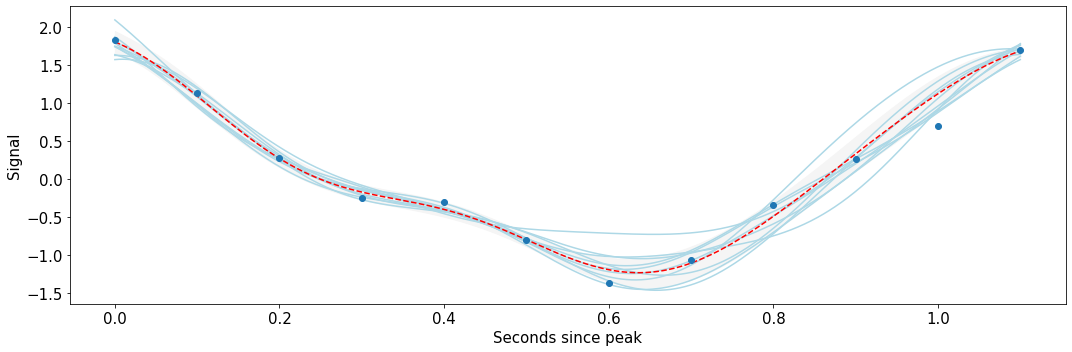

<Figure size 432x288 with 0 Axes>

In [15]:
subj19gp, subj19SampleMats,subj19main = GP_fitting(subject19, timespan = 1.1,ell=0.06)
plt.tight_layout()
subj19main.savefig("./Figures/subj19main")

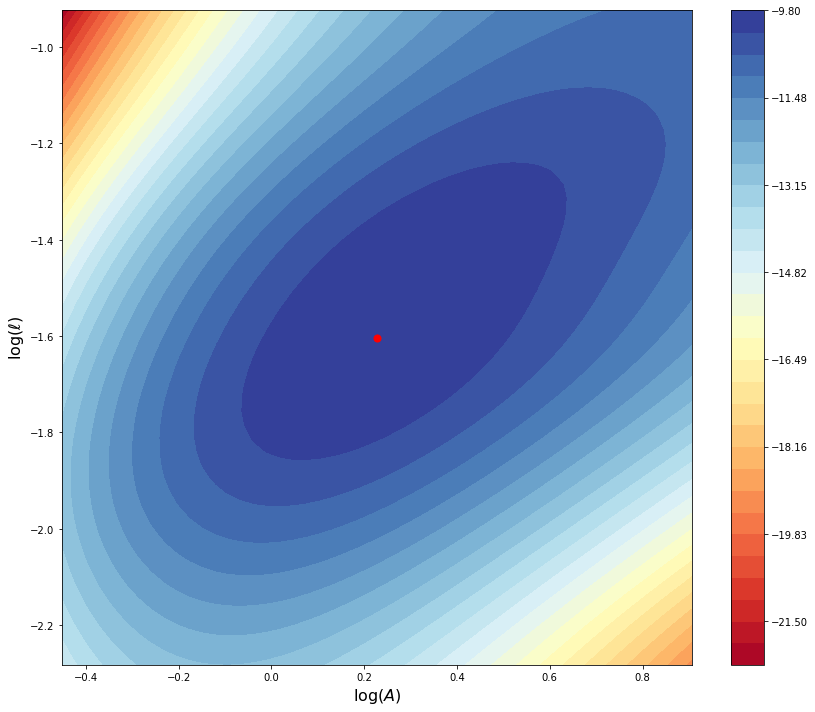

In [16]:
subj19paramsfig = parameter_optimisation(subj19gp)
subj19paramsfig.savefig("./Figures/subj19paramsfig")

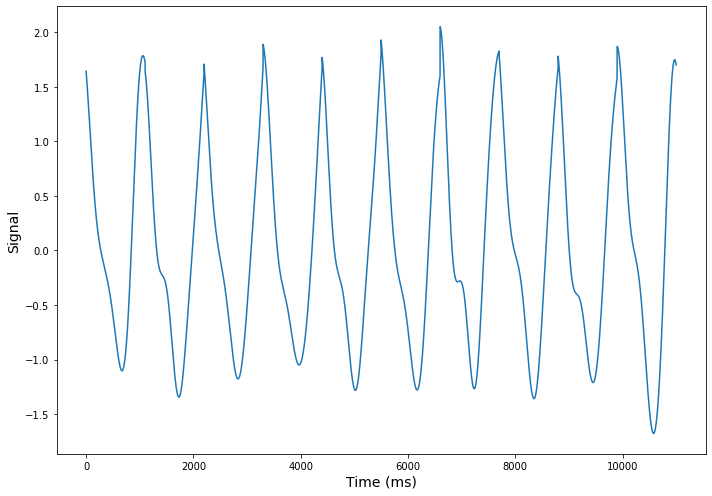

In [17]:
subj19 = subj19SampleMats[:, 0:10].flatten('F')
plt.figure(figsize=(10,7))
plt.plot(subj19)
plt.ylabel("Signal",fontsize=14)
plt.xlabel("Time (ms)",fontsize=14)
plt.tight_layout()
plt.savefig("./Figures/subj19trace")

In [18]:
#time < 0
def fraction_below_zero(SampleMat):
    
    fractions = []
    for i in range (0, SampleMat.shape[1]):
            x = SampleMat[:,i]
            fraction = x[x<0].size/x.size
            fractions = np.append(fractions,fraction)
            
    return fractions

In [19]:
subj8fractions =fraction_below_zero(subj8SampleMats)
subj12fractions = fraction_below_zero(subj12SampleMats)
subj19fractions = fraction_below_zero(subj19SampleMats)

In [20]:
subjectfractions = pd.DataFrame({
    'Subject 8': subj8fractions,
    'Subject 12': subj12fractions,
    'Subject 19': subj19fractions
})

In [21]:
#time taken to reach min after peak
#lukily argmin represents time---> /1000 to get to proper scaled
subj8times = np.argmin(subj8SampleMats,axis=0)/1000
subj12times = np.argmin(subj12SampleMats,axis=0)/1000
subj19times = np.argmin(subj19SampleMats,axis=0)/1000

In [22]:
subjecttimes = pd.DataFrame({
    'Subject 8': subj8times,
    'Subject 12': subj12times,
    'Subject 19': subj19times
})

In [23]:
#minimums from each sample
subj8minima = np.min(subj8SampleMats,axis=0)
subj12minima =np.min(subj12SampleMats,axis=0)
subj19minima = np.min(subj19SampleMats,axis=0)

In [24]:
subjectminima =  pd.DataFrame({
    'Subject 8': subj8minima,
    'Subject 12': subj12minima,
    'Subject 19': subj19minima
})

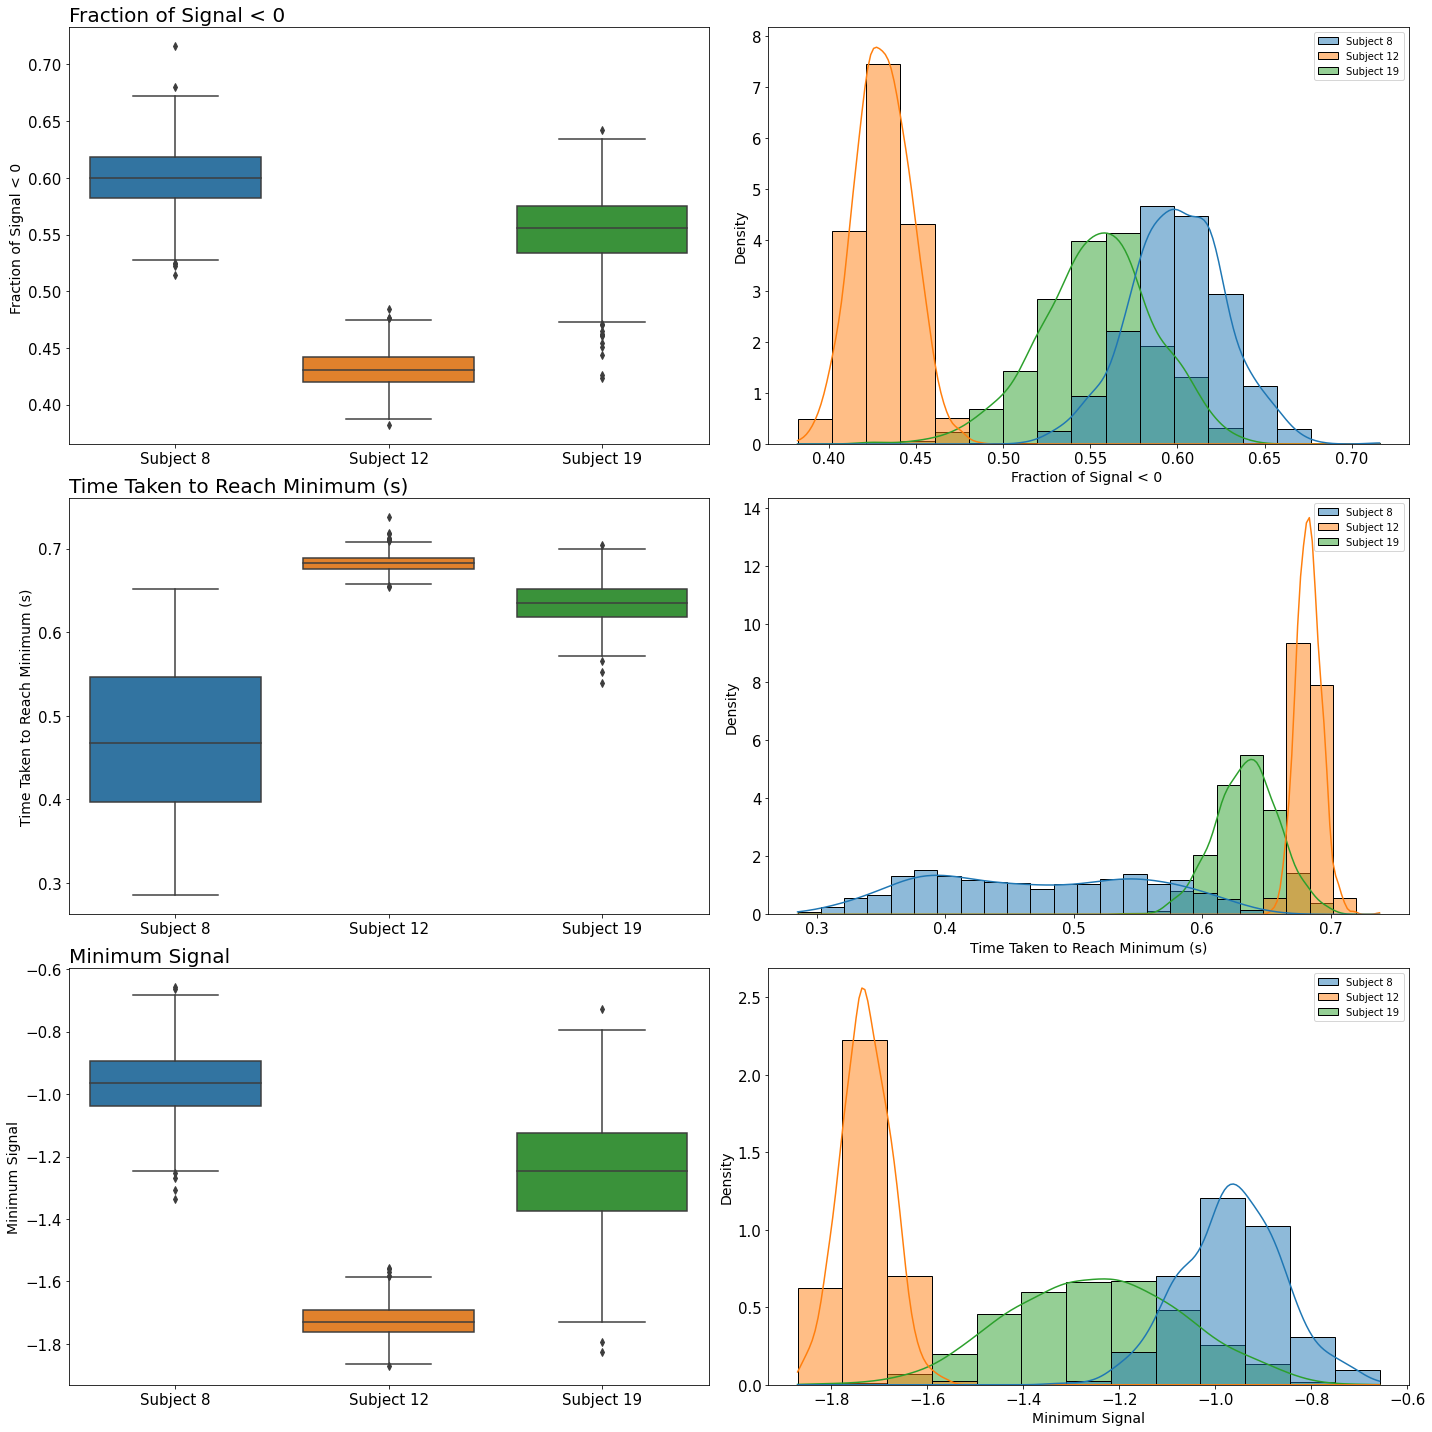

In [25]:
plt.figure(figsize=(20,20))

plt.subplot(3,2,1)
sns.boxplot(data = subjectfractions)
plt.ylabel("Fraction of Signal < 0 ", fontsize=14)
plt.title("Fraction of Signal < 0 ",fontsize=20,loc='left')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.subplot(3,2,2)
sns.histplot(data = subjectfractions,stat="density",kde = True)
plt.ylabel("Density", fontsize=14)
plt.xlabel("Fraction of Signal < 0 ", fontsize=14)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.subplot(3,2,3)
sns.boxplot(data=subjecttimes)
plt.ylabel("Time Taken to Reach Minimum (s)" , fontsize=14)
plt.title("Time Taken to Reach Minimum (s)",fontsize=20,loc='left')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.subplot(3,2,4)
sns.histplot(data = subjecttimes,stat="density",kde = True)
plt.ylabel("Density", fontsize=14)
plt.xlabel("Time Taken to Reach Minimum (s)", fontsize=14)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.subplot(3,2,5)
sns.boxplot(data=subjectminima)
plt.ylabel("Minimum Signal", fontsize=14)
plt.title("Minimum Signal",fontsize=20,loc='left')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.subplot(3,2,6)
sns.histplot(data = subjectminima, stat="density", kde = True)
plt.ylabel("Density", fontsize=14)
plt.xlabel("Minimum Signal", fontsize=14)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.tight_layout()

plt.savefig("./Figures/BoxesAndHists.png")

In [27]:
#gradients between different times intervals
def gradient(SampleMat,coarselevel):
    SampleMatGradients = [np.gradient(SampleMat[0:int(SampleMat.shape[0]):coarselevel,i]) for i in range(0,SampleMat.shape[1])]
    SampleMatGradients = pd.DataFrame(SampleMatGradients)
    return SampleMatGradients

In [28]:
#fine gradient intervals 
finesubj19 = gradient(subj19SampleMats,10)
finesubj12 = gradient(subj12SampleMats,10)
finesubj8 =  gradient(subj8SampleMats,10)

In [29]:
#coarse gradient intervals
coarsesubj8 = gradient(subj8SampleMats,100)
coarsesubj12 = gradient(subj12SampleMats,100)
coarsesubj19 = gradient(subj19SampleMats,100)

In [30]:
#quarters
coarse_subj8 = gradient(subj8SampleMats,250)
coarse_subj12 = gradient(subj12SampleMats,250)
coarse_subj19 = gradient(subj19SampleMats,250)

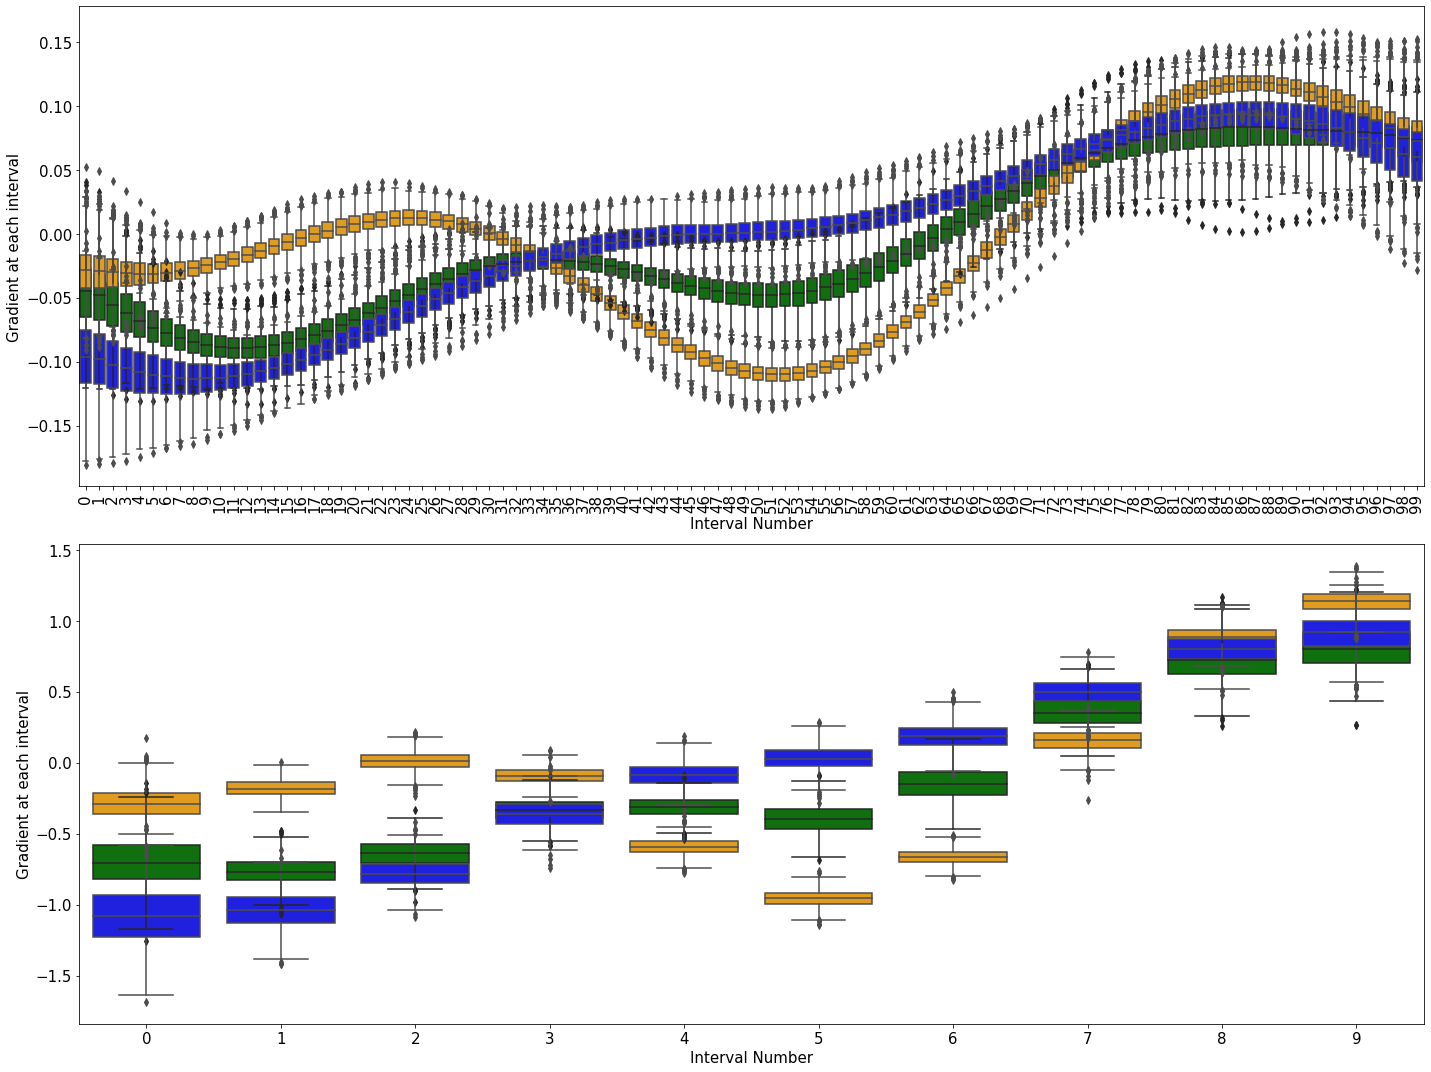

In [31]:
plt.figure(figsize=(20,15))
plt.xticks(fontsize=15)
#plot fine gradients
plt.subplot(2,1,1)
plt.xlabel("Interval Number",fontsize=15)
plt.ylabel('Gradient at each interval',fontsize=15)
sns.boxplot(data=finesubj19,color='green')
sns.boxplot(data=finesubj12,color='orange')
sns.boxplot(data=finesubj8,color = 'blue')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15,rotation=90)
plt.subplot(2,1,2)
plt.xlabel("Interval Number",fontsize=15)
plt.ylabel('Gradient at each interval',fontsize=15)
sns.boxplot(data=coarsesubj19,color='green')
sns.boxplot(data=coarsesubj12,color='orange')
sns.boxplot(data=coarsesubj8,color = 'blue')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.tight_layout()
plt.savefig("./Figures/Gradients.png")

In [32]:
# inteval number 5 corresponds to interval 0.5-0.6 in coarse gradients
subjectgradientFiveSix =  pd.DataFrame({
    'Subject 8': coarsesubj8[5],
    'Subject 12': coarsesubj12[5],
    'Subject 19': coarsesubj19[5]
})

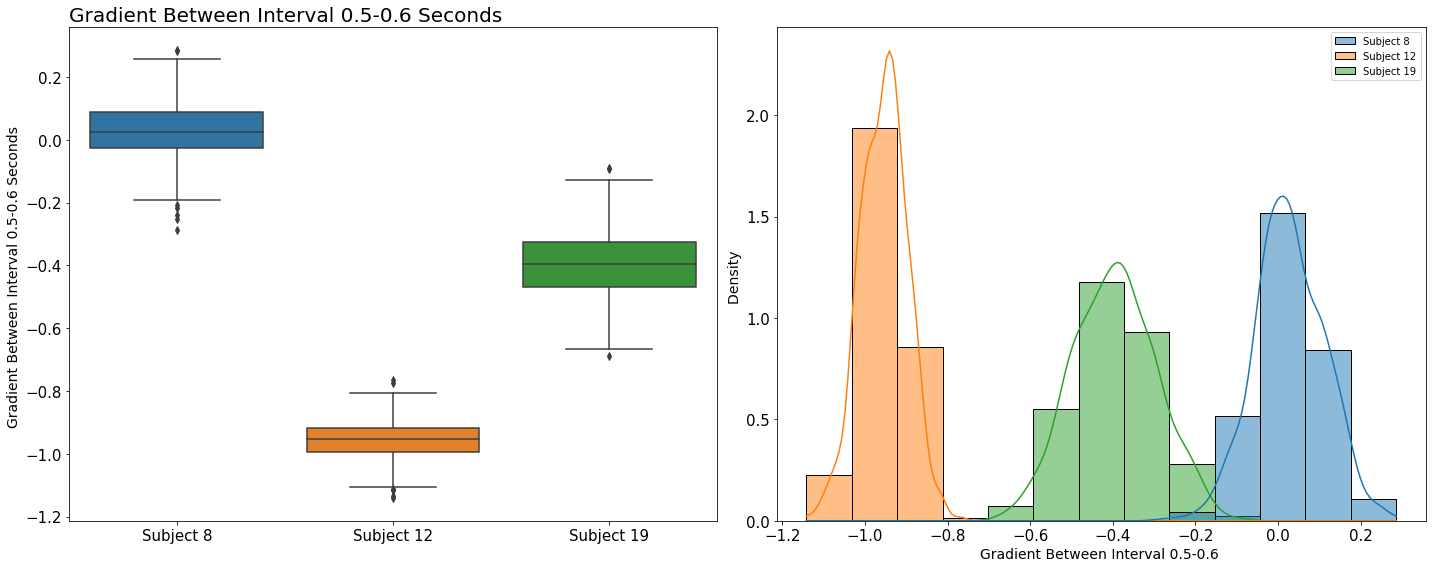

In [33]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.boxplot(data = subjectgradientFiveSix)
plt.ylabel("Gradient Between Interval 0.5-0.6 Seconds ",fontsize=14)
plt.title("Gradient Between Interval 0.5-0.6 Seconds ",fontsize=20,loc='left')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.subplot(1,2,2)
sns.histplot(data = subjectgradientFiveSix,stat="density",kde = True)
plt.ylabel("Density ",fontsize=14)
plt.xlabel("Gradient Between Interval 0.5-0.6 ",fontsize=14)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.tight_layout()
plt.savefig("./Figures/Gradientsbox")

In [34]:
# quantifying difference between scores for different subjects
# difference is quantified by comparing medians with overall range of a pair of distributions
def distinguish(dataframe):
    
    dataframe = dataframe.quantile([.25,.5,.75], axis = 0)
    dataframe = dataframe.T
    dataframe['IQR'] = dataframe[0.75]- dataframe[0.25]
    dataframe['upperwisker'] = dataframe[0.75] + 1.5*dataframe['IQR']
    dataframe['lowerwisker'] = dataframe[0.25] - 1.5*dataframe['IQR']
    
    #get relevant information 

    
    #subj8 = dataframe.loc["Subject 8",[0.5,0.25,0.75]].to_numpy()
    #subj12 = dataframe.loc["Subject 12",[0.5,0.25,0.75]].to_numpy()
    #subj19 = dataframe.loc["Subject 19",[0.5,0.25,0.75]].to_numpy()
    
    subj8 = dataframe.loc["Subject 8",[0.5,"lowerwisker", "upperwisker"]].to_numpy()
    subj12 = dataframe.loc["Subject 12",[0.5,"lowerwisker", "upperwisker"]].to_numpy()
    subj19 = dataframe.loc["Subject 19",[0.5,"lowerwisker", "upperwisker"]].to_numpy()

    
    #8vs12
    s8v12 = 100 * (subj8[0] - subj12[0]) / (max(subj8[2],subj12[2]) - min(subj8[1],subj12[1]))
    if s8v12 < 0:
        s8v12 = s8v12*-1
    
    #8vs19
    s8v19 = 100 * (subj8[0] - subj19[0]) / (max(subj8[2],subj19[2]) - min(subj8[1],subj19[1]))
    if s8v19 < 0:
        s8v19 = s8v19*-1
        
    #12vs19
    s12v19 = 100 * (subj12[0] - subj19[0]) / (max(subj12[2],subj19[2]) - min(subj12[1],subj19[1]))
    if s12v19 < 0:
        s12v19 = s12v19*-1
    
    array = [s8v12,s8v19,s12v19]
    
    return subj8,subj12,subj19, array

In [35]:
s8minimarange, s12minimarange, s19minimarange, minima = distinguish(subjectminima)
s8gradientrange, s12gradientrange, s19gradientrange, gradient = distinguish(subjectgradientFiveSix)
s8fractionrange, s12fractionrange, s19fractionrange, fractions = distinguish(subjectfractions)
s8timesrange, s12timesrange, s19timesrange, times = distinguish(subjecttimes)

In [36]:
differences = pd.DataFrame({
    "Minimum Signal": minima,
    "Gradient between 0.5-0.6 seconds": gradient,
    "Fraction of Signal Below < 0": fractions,
    "Time taken to reach Minimum": times
    
}, index = ["% Diff 8 vs 12","% Diff 8 vs 19", "%Diff 12 vs 19"]).round(2).T


In [37]:
differences

,% Diff 8 vs 12,% Diff 8 vs 19,%Diff 12 vs 19
Minimum Signal,64.44,26.49,42.98
Gradient between 0.5-0.6 seconds,71.24,44.63,55.65
Fraction of Signal Below < 0,59.30,22.27,49.89
Time taken to reach Minimum,36.16,28.10,33.92


In [220]:
#differences = differences.round(2).T
differences['Average'] = np.mean(differences,axis=1).round(2)
differences

,% Diff 8 vs 12,% Diff 8 vs 19,%Diff 12 vs 19,Average
Minimum Signal,64.44,26.49,42.98,44.64
Gradient between 0.5-0.6 seconds,71.24,44.63,55.65,57.17
Fraction of Signal Below < 0,59.30,22.27,49.89,43.82
Time taken to reach Minimum,36.16,28.10,33.92,32.73


In [38]:
def overlap(range1,range2):
    
    max_minimum = max(range1[1],range2[1])
    min_maximum = min(range1[2],range2[2])

    max_maximum = max(range1[2],range2[2])
    min_minimum = min(range1[1],range2[1])

    total_range = max_maximum - min_minimum

    overlap = min_maximum - max_minimum 

    if min_maximum >  max_minimum:
        percentage_overlap = 100*overlap / total_range
        
    else:
        percentage_overlap = 0

    if percentage_overlap < 0:
        percentage_overlap = percentage_overlap*-1
    
    return percentage_overlap

In [39]:
#8vs12
eightvstwelve_minima_overlap = overlap(s8minimarange,s12minimarange)

eightvstwelve_gradient_overlap = overlap(s8gradientrange,s12gradientrange)

eightvstwelve_times_overlap = overlap(s8timesrange,s12timesrange)

eightvstwelve_fractions_overlap = overlap(s8fractionrange,s12fractionrange)


In [40]:
#8vs19
eightvsnineteen_minima_overlap = overlap(s8minimarange,s19minimarange)
eightvsnineteen_gradient_overlap = overlap(s8gradientrange,s19gradientrange)
eightvsnineteen_times_overlap = overlap(s8timesrange,s19timesrange)
eightvsnineteen_fractions_overlap = overlap(s8fractionrange,s19fractionrange)

In [41]:
#12vs19
twelvevsnineteen_minima_overlap = overlap(s12minimarange,s19minimarange)
twelvevsnineteen_gradient_overlap = overlap(s12gradientrange,s19gradientrange)
twelvevsnineteen_times_overlap = overlap(s12timesrange,s19timesrange)
twelvevsnineteen_fractions_overlap = overlap(s12fractionrange,s19fractionrange)

In [42]:
overlaps = pd.DataFrame({
    "Minimum Signal": 
    {
        '% Overlap 8 vs 12': eightvstwelve_minima_overlap,
        '% Overlap 8 vs 19': eightvsnineteen_minima_overlap,
        '% Overlap 12 vs 19': twelvevsnineteen_minima_overlap 
    },
    "Gradient between 0.5-0.6 seconds":
    {
        '% Overlap 8 vs 12': eightvstwelve_gradient_overlap,
        '% Overlap 8 vs 19': eightvsnineteen_gradient_overlap,
        '% Overlap 12 vs 19': twelvevsnineteen_gradient_overlap 
    },
    "Time taken to reach Minimum":
    {
        '% Overlap 8 vs 12': eightvstwelve_times_overlap,
        '% Overlap 8 vs 19': eightvsnineteen_times_overlap,
        '% Overlap 12 vs 19': twelvevsnineteen_times_overlap
    },
    "Fraction of Signal Below < 0":
    {
        '% Overlap 8 vs 12': eightvstwelve_fractions_overlap,
        '% Overlap 8 vs 19': eightvsnineteen_fractions_overlap,
        '% Overlap 12 vs 19': twelvevsnineteen_fractions_overlap
    }
}).round(2).T

In [43]:
overlaps

,% Overlap 8 vs 12,% Overlap 8 vs 19,% Overlap 12 vs 19
Minimum Signal,0.00,47.16,14.85
Gradient between 0.5-0.6 seconds,0.00,9.37,0.00
Time taken to reach Minimum,8.72,22.82,32.86
Fraction of Signal Below < 0,0.00,54.22,1.23


In [223]:
overlaps['Average'] = np.mean(overlaps,axis=1)
overlaps.round(2)

,% Overlap 8 vs 12,% Overlap 8 vs 19,% Overlap 12 vs 19,Average
Minimum Signal,0.00,47.16,14.85,20.67
Gradient between 0.5-0.6 seconds,0.00,9.37,0.00,3.12
Time taken to reach Minimum,8.72,22.82,32.86,21.47
Fraction of Signal Below < 0,0.00,54.22,1.23,18.48


In [225]:
differences

,% Diff 8 vs 12,% Diff 8 vs 19,%Diff 12 vs 19,Average
Minimum Signal,64.44,26.49,42.98,44.64
Gradient between 0.5-0.6 seconds,71.24,44.63,55.65,57.17
Fraction of Signal Below < 0,59.30,22.27,49.89,43.82
Time taken to reach Minimum,36.16,28.10,33.92,32.73
